#  <center> Speech Emotion Recognition <center>

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torchaudio.transforms import Resample, MelSpectrogram
import torch
import torchaudio
from torchaudio.transforms import Resample, MelSpectrogram
from torch.utils.data import Dataset
import librosa
import numpy as np
import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [3]:

# Assuming you have a list of file paths and corresponding emotion labels for SAVEE
savee_directory_list = os.listdir("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL")
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(os.path.join("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL", file))
    split_part = file.split('_')
    if len(split_part) >= 2:
        part = split_part[1]
        ele = part[:-6]
        if ele == 'a':
            file_emotion.append('angry')
        elif ele == 'd':
            file_emotion.append('disgust')
        elif ele == 'f':
            file_emotion.append('fear')
        elif ele == 'h':
            file_emotion.append('happy')
        elif ele == 'n':
            file_emotion.append('neutral')
        elif ele == 'sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
    else:
        file_emotion.append('Unknown')

In [4]:

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Encode emotion labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Savee_df['Emotions'])

# Split dataset into train and test with stratification
train_paths, test_paths, train_labels, test_labels = train_test_split(
    Savee_df['Path'].tolist(), encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

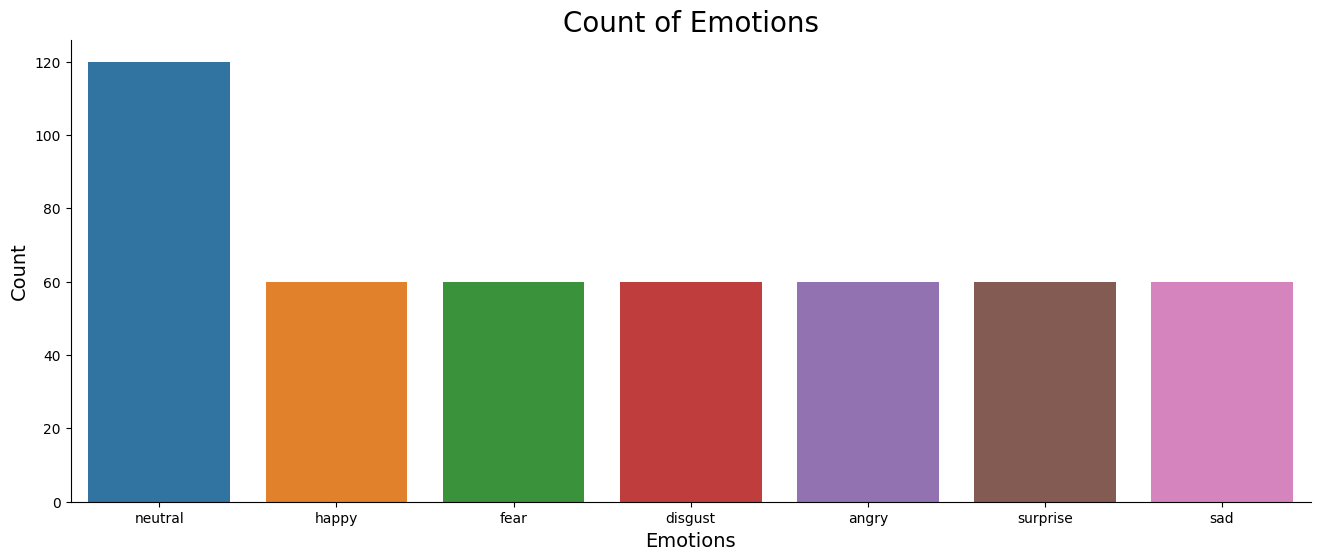

In [5]:
# Assuming you have a DataFrame named Savee_df
plt.figure(figsize=(16, 6))
plt.title('Count of Emotions', size=20)
sns.countplot(data=Savee_df, x='Emotions', order=Savee_df['Emotions'].value_counts().index)
plt.ylabel('Count', size=14)
plt.xlabel('Emotions', size=14)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [6]:
# Now, for visualization, you can use the following code:

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.linspace(0, len(data) / sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

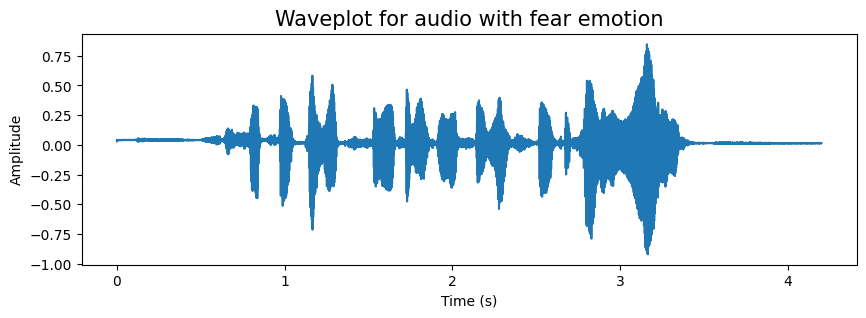

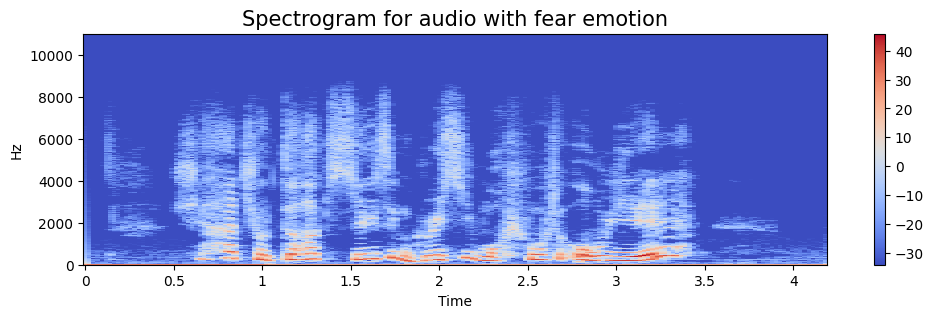

In [7]:
emotion='fear'
path = np.array(Savee_df.Path[Savee_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

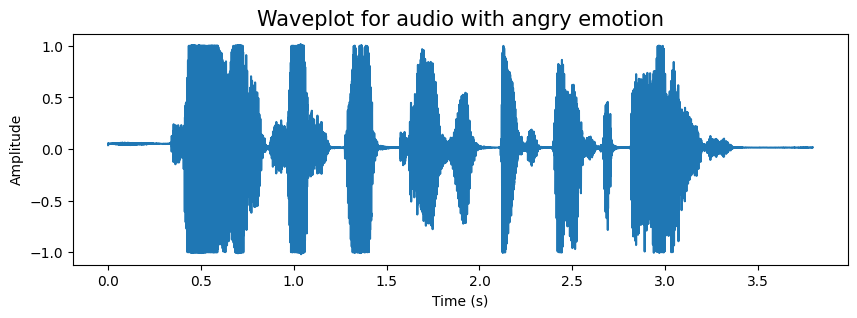

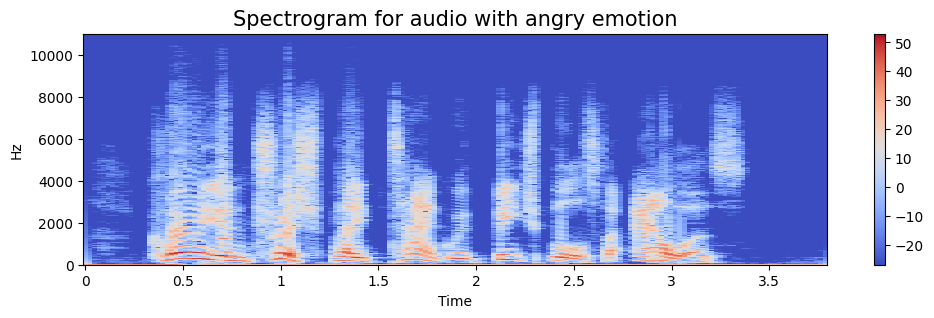

In [8]:
emotion='angry'
path = np.array(Savee_df.Path[Savee_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

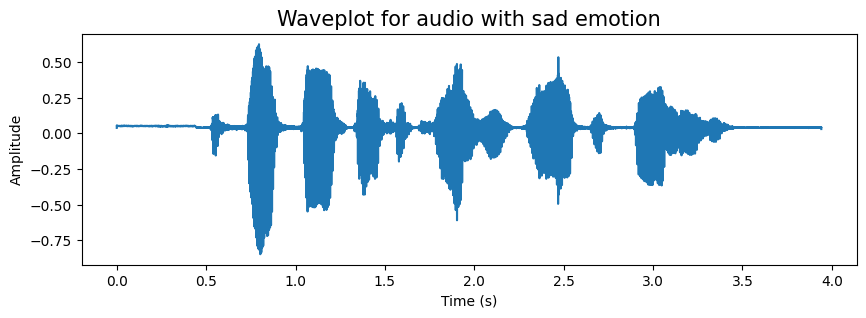

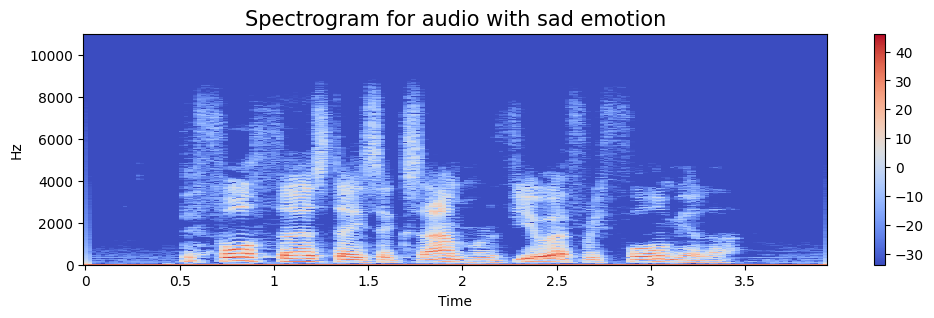

In [9]:
emotion='sad'
path = np.array(Savee_df.Path[Savee_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

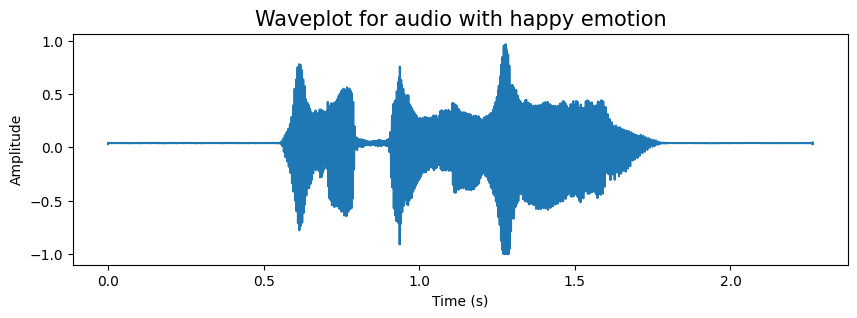

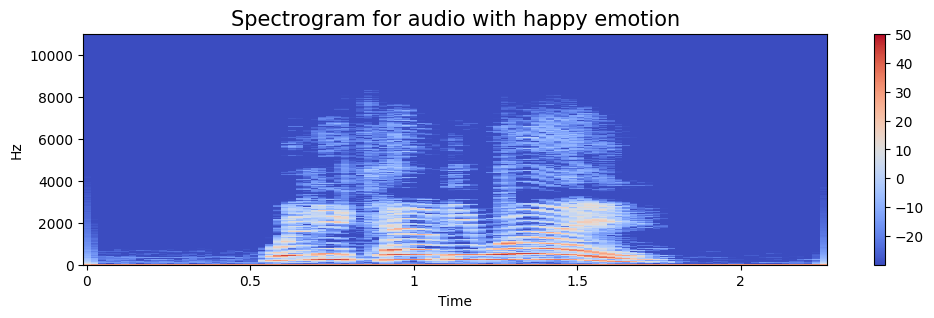

In [10]:
emotion='happy'
path = np.array(Savee_df.Path[Savee_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Processing Data

In [11]:
class SaveeDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
        self.resample = Resample(48000, 16000)
        self.mel_spec = MelSpectrogram()
        self.max_len = 196  # Adjust this value based on your dataset

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, rate = torchaudio.load(self.file_paths[idx])
        audio = self.resample(audio)
        mel_spec = self.mel_spec(audio)
        
        # Pad the mel spectrogram to a fixed size
        pad_value = 0  # You can change this value if needed
        if mel_spec.shape[2] < self.max_len:
            padding = torch.zeros((1, mel_spec.shape[1], self.max_len - mel_spec.shape[2]))
            mel_spec = torch.cat([mel_spec, padding], dim=2)
        elif mel_spec.shape[2] > self.max_len:
            mel_spec = mel_spec[:, :, :self.max_len]

        label = self.labels[idx]
        return mel_spec, label

In [12]:
# Create datasets and data loaders
train_dataset = SaveeDataset(train_paths, train_labels)
test_dataset = SaveeDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Model Building

In [13]:
# Load a pre-trained model from torchaudio
pretrained_model = models.densenet121(pretrained=True)
pretrained_model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Change input channels to 1

# Modify the classifier layer for the number of output classes
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, len(set(encoded_labels)))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Training loop with tqdm
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 168MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:

for epoch in range(num_epochs):
    # Wrap train_loader with tqdm for a progress bar
    train_loader_iter = tqdm.tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

    for inputs, labels in train_loader_iter:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    pretrained_model.eval()
    correct = 0
    total = 0
# Wrap test_loader with tqdm for a progress bar
    test_loader_iter = tqdm.tqdm(test_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Evaluating', leave=False)

    with torch.no_grad():
        for inputs, labels in test_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy (Epoch {epoch + 1}): {accuracy * 100:.2f}%')

    pretrained_model.train()  # Set the model back to training mode


Test Accuracy (Epoch 1): 32.29%


Test Accuracy (Epoch 2): 35.42%


Test Accuracy (Epoch 3): 38.54%


Test Accuracy (Epoch 4): 43.75%


Test Accuracy (Epoch 5): 39.58%


Test Accuracy (Epoch 6): 37.50%


Test Accuracy (Epoch 7): 43.75%


Test Accuracy (Epoch 8): 50.00%


Test Accuracy (Epoch 9): 50.00%


Test Accuracy (Epoch 10): 41.67%


## Model Evaluation

In [15]:
# Assuming you have a variable named pretrained_model for your trained model
num_epochs = 10  # Replace with the actual number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

for epoch in range(num_epochs):
    # Training loop
    pretrained_model.train()
    total_train_correct = 0
    total_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_loss += loss.item()

    average_train_accuracy = total_train_correct / len(train_loader.dataset)
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(average_train_accuracy)
    train_loss_list.append(average_train_loss)

    # Testing loop
    pretrained_model.eval()
    with torch.no_grad():
        total_test_correct = 0
        total_test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_loss += loss.item()

        average_test_accuracy = total_test_correct / len(test_loader.dataset)
        average_test_loss = total_test_loss / len(test_loader)
        test_accuracy_list.append(average_test_accuracy)
        test_loss_list.append(average_test_loss)




Accuracy of our model on test data:  0.4166666666666667 %


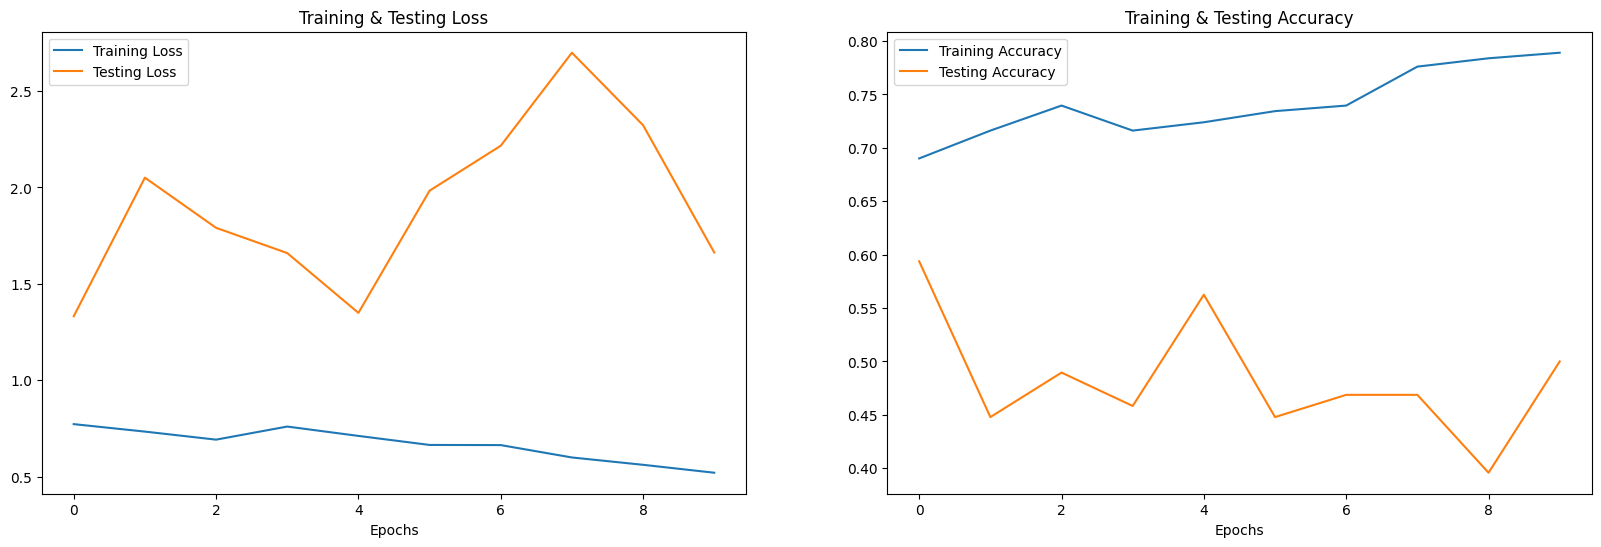

In [16]:
# Assuming you have a variable named pretrained_model for your trained model
print("Accuracy of our model on test data: ", accuracy, "%")

# Plotting
epochs = [i for i in range(num_epochs)]
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss_list, label='Training Loss')
ax[0].plot(epochs, test_loss_list, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy_list, label='Training Accuracy')
ax[1].plot(epochs, test_accuracy_list, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [30]:
# Assuming you have a trained model named pretrained_model
pretrained_model.eval()

# Assuming you have a DataLoader named test_loader
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
y_pred = np.array(all_predictions)
y_true = np.array(all_labels)

# Assuming you have label_encoder for decoding predictions
y_pred_1 = label_encoder.inverse_transform(y_pred)
y_true_1 = label_encoder.inverse_transform(y_true)
# Print or use the decoded predictions as needed
print(y_pred_1)


['sad' 'fear' 'sad' 'neutral' 'neutral' 'surprise' 'neutral' 'surprise'
 'surprise' 'sad' 'neutral' 'neutral' 'sad' 'surprise' 'surprise' 'sad'
 'fear' 'neutral' 'neutral' 'fear' 'neutral' 'neutral' 'neutral' 'sad'
 'neutral' 'neutral' 'disgust' 'neutral' 'sad' 'sad' 'fear' 'surprise'
 'sad' 'neutral' 'fear' 'neutral' 'sad' 'happy' 'neutral' 'fear' 'neutral'
 'surprise' 'fear' 'neutral' 'surprise' 'surprise' 'neutral' 'neutral'
 'happy' 'surprise' 'neutral' 'sad' 'neutral' 'neutral' 'neutral' 'sad'
 'surprise' 'fear' 'fear' 'neutral' 'surprise' 'sad' 'neutral' 'neutral'
 'happy' 'neutral' 'neutral' 'disgust' 'fear' 'sad' 'sad' 'neutral' 'fear'
 'sad' 'neutral' 'fear' 'fear' 'disgust' 'neutral' 'neutral' 'sad'
 'surprise' 'neutral' 'sad' 'neutral' 'angry' 'surprise' 'fear' 'fear'
 'sad' 'neutral' 'surprise' 'neutral' 'neutral' 'surprise' 'surprise']


In [31]:
# Assuming you have imported classification_report
print(classification_report(y_true_1, y_pred_1))

              precision    recall  f1-score   support

       angry       1.00      0.08      0.15        12
     disgust       0.33      0.08      0.13        12
        fear       0.47      0.58      0.52        12
       happy       0.67      0.17      0.27        12
     neutral       0.55      0.88      0.68        24
         sad       0.42      0.67      0.52        12
    surprise       0.47      0.67      0.55        12

    accuracy                           0.50        96
   macro avg       0.56      0.45      0.40        96
weighted avg       0.56      0.50      0.44        96

